# NIRSpec IFU plotting notebook

Author: Jonathan Aguilar (jaguilar@stsci.edu)

This notebook visualizes source placement for NIRSpec IFU observations, for a given orientation of the telescope. It shows the footprint of individual NIRSpec slices within a given channel. For a more general introduction to WHIPPOT, see [WHIPPOT_tutorial](WHIPPOT_tutorial).

WHIPPOT was originally designed for observations that use target acquisition on one star and then manually command the slew to another. Generally, users planning without TA or with self-TA should simply provide the same coordinates for their ACQ target as for their SCI target. 

The user provides the RA and Dec coordinates for the target acquisition (ACQ) star and science (SCI) star, and a telescope roll angle. These tools will then compute a) the "Special Requirement Offset" X and Y values needed to place the SCI star at the reference position (if performing manual offset TA), and b) the final coordinates of the SCI and ACQ stars. Coordinates are given in IDL coordinates, in units of arcsec (https://jwst-docs.stsci.edu/jwst-observatory-hardware/jwst-target-observability-and-observatory-coordinate-system/jwst-instrument-ideal-coordinate-systems#gsc.tab=0).

The user can also provide a list of extra targets in the field in the format specified below, and their IDL coordinates will also be computed. As such, this notebook is useful not just for planning target acquisition, but also for predicting to high precision the final positions of astronomical bodies in the field of view.

## Setup ##

  1. Navigate in a terminal to the directory where you have downloaded the module. This should contain the `setup.py` file.
  2. Activate your desired python environment.
  3. Run `pip install .` (or `pip install -e.` for developing)
  4. Copy this notebook to your working directory, and run your jupyter kernel in the appropriate environment.

In [1]:
# for development purposes
%load_ext autoreload
%autoreload 2

In [2]:
# for your system, choose an appropriate plotting backend to make pop-up window plots
# (currently, inline plots show up in the log but not directly in the notebook).
# %matplotlib throws an error if you run it first, so do inline first.
%matplotlib inline
%matplotlib osx

In [3]:
from whippot import whippot_tools

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-071 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-072
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


## An example system

Let's say we want spectroscopy of HD 19467 B, a well-characterized T-dwarf companion to a G-type star, and we need to make sure the diffraction spikes don't overlap. WHIPPOT requires RA and Dec coordinates for all sources, but the positions of imaged low-mass companions are usually given relative to the host star. We can use astropy's handy SkyCoord object to make the conversion simple. We'll get the offsets from http://whereistheplanet.com/ as delta RA and delta Dec, but SkyCoord can also work with separation and position angle.

In [4]:
hd19467 = whippot_tools.SkyCoord.from_name("HD 19467")
from astropy import units
companion = hd19467.spherical_offsets_by(-1295.015*units.mas, -901.199*units.mas)
sources = {
    'SCI': hd19467,
    'b': companion,
}

In [5]:
from astropy import units
initial_values={
    'instr': 'nirspec',
    'sci_aper': 'nrs_full_ifu', 
    'pa': 0.,
    'sci_ra': sources['SCI'].ra.deg, 'sci_dec': sources['SCI'].dec.deg,
    'show_diffraction_spikes': True,
}
# add a multi-line string of the other stars, copied from the cell above
initial_values['other_stars'] = "\n".join(f"{k}: ({v.ra.deg}, {v.dec.deg})" for k, v in sources.items() if k not in ['SCI'])

## Use the NIRSpec IFU-specific ComputePositions class

The ComputePositions class in `nirspec_ifu_tools.py` is a subclass of the general `ComputePositions` class that adds NIRSPEC IFU-specific overlays to the plots.

In [6]:
from whippot.modes import nirspec_ifu_tools
cp1 = nirspec_ifu_tools.ComputePositions(initial_values=initial_values)
cp1.ui

Uh oh, the companion is kind of close to the edge, and the diffraction spikes overlap! I used the GUI above to find that a PA angle of 20 degrees clears the diffraction spikes.

Let's also apply an X/Y offset to the primary and move the companion closer to the middle of the detector.

In [7]:
cp1.parameter_values['pa'] = 20
cp1.parameter_values['final_idl_x'] = 1
# we have to tell `compute_positions()` to ignore the state of the widgets,
# or it will overwrite our changes
cp1.compute_positions(update_params_from_widgets=False)
fig = cp1.plot_scene()

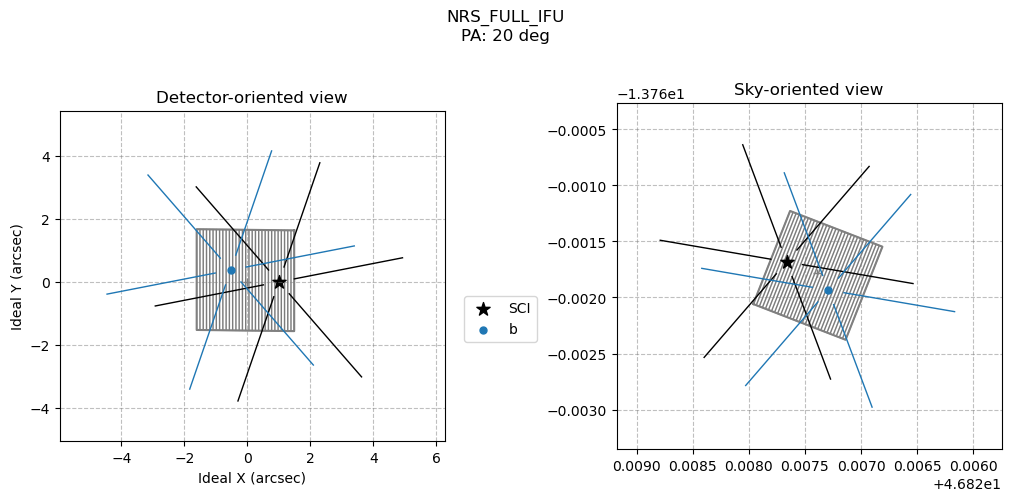

In [8]:
# Show the output plot in the notebook instead of in a popup window
%matplotlib inline
cp1.plot_scene()